[*********************100%%**********************]  1 of 1 completed

Fetching stock data...

Preparing features...

Splitting data...

Training XGBoost model...



Making predictions...

Model Performance Metrics:
Mean Squared Error (MSE): 142.90
Mean Absolute Error (MAE): 9.04
Root Mean Squared Error (RMSE): 11.95
Mean Absolute Percentage Error (MAPE): 4.81%

Predicting future prices...


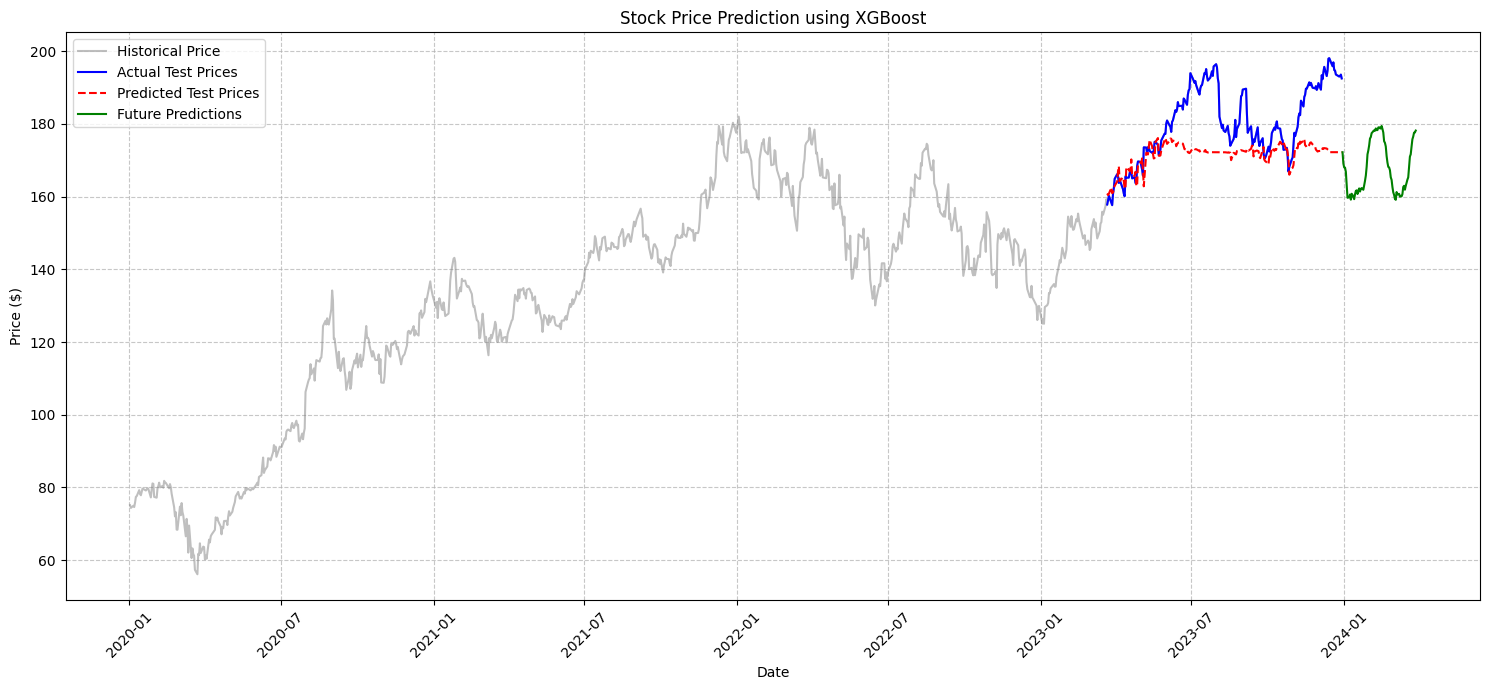


Sample of future predictions:
2023-12-30: $172.23
2024-01-14: $160.64
2024-01-29: $171.63
2024-02-13: $178.80
2024-02-28: $162.64
2024-03-14: $161.90

Final prediction for 2024-03-27:
Price: $178.18


In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# Step 1: Fetch data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data from Yahoo Finance
    
    Args:
    - ticker: Stock symbol
    - start_date: Start date for data retrieval
    - end_date: End date for data retrieval
    
    Returns:
    - DataFrame with stock data
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Step 2: Prepare features for XGBoost
def prepare_features(data, lookback=30):
    """
    Create time series features from stock data
    
    Args:
    - data: DataFrame with stock prices
    - lookback: Number of previous days to use as features
    
    Returns:
    - X: Feature matrix
    - y: Target vector (next day's closing price)
    """
    # Initialize scaler
    price_scaler = MinMaxScaler()
    
    # Scale prices
    prices = data['Close'].values
    prices_scaled = price_scaler.fit_transform(prices.reshape(-1, 1)).flatten()
    
    # Create feature matrix
    X, y = [], []
    for i in range(len(prices_scaled) - lookback):
        X.append(prices_scaled[i:i+lookback])
        y.append(prices_scaled[i+lookback])
    
    return np.array(X), np.array(y), price_scaler

# Step 3: Prepare train and test datasets
def prepare_data(X, y, test_size=0.2):
    """
    Split data into training and testing sets
    
    Args:
    - X: Feature matrix
    - y: Target vector
    - test_size: Proportion of data to use for testing
    
    Returns:
    - Training and testing splits
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        shuffle=False
    )
    
    return X_train, X_test, y_train, y_test

# Step 4: Train XGBoost model
def train_xgboost_model(X_train, y_train, X_test, y_test):
    """
    Train XGBoost regression model
    
    Args:
    - X_train: Training feature matrix
    - y_train: Training target vector
    - X_test: Testing feature matrix
    - y_test: Testing target vector
    
    Returns:
    - Trained XGBoost model
    """
    # Define parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    # Create and train model
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    return model

# Step 5: Make predictions
def make_predictions(model, X_test):
    """
    Make predictions on test set
    
    Args:
    - model: Trained XGBoost model
    - X_test: Testing feature matrix
    
    Returns:
    - Predictions
    """
    predictions = model.predict(X_test)
    return predictions

# Step 6: Evaluate model performance
def evaluate_model(actual, predictions, price_scaler):
    """
    Evaluate model performance
    
    Args:
    - actual: Actual price values
    - predictions: Predicted price values
    - price_scaler: MinMaxScaler used for price scaling
    
    Returns:
    - Performance metrics
    """
    # Inverse transform predictions
    actual_original = price_scaler.inverse_transform(actual.reshape(-1, 1))
    predictions_original = price_scaler.inverse_transform(predictions.reshape(-1, 1))
    
    # Calculate metrics
    mse = mean_squared_error(actual_original, predictions_original)
    mae = mean_absolute_error(actual_original, predictions_original)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_original - predictions_original) / actual_original)) * 100
    
    print("\nModel Performance Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    return mse, mae, rmse, mape

# Step 7: Forecast future prices
def predict_future_prices(model, last_prices, price_scaler, days=89):
    """
    Forecast future prices using the trained model
    
    Args:
    - model: Trained XGBoost model
    - last_prices: Last 'lookback' days of prices
    - price_scaler: MinMaxScaler used for price scaling
    - days: Number of days to forecast
    
    Returns:
    - Future price predictions
    """
    # Scale last prices
    last_prices_scaled = price_scaler.transform(last_prices.reshape(-1, 1)).flatten()
    
    # Forecast
    future_predictions_scaled = []
    current_window = last_prices_scaled.copy()
    
    for _ in range(days):
        # Predict next price
        next_pred = model.predict(current_window.reshape(1, -1))[0]
        
        # Append scaled prediction
        future_predictions_scaled.append(next_pred)
        
        # Update sliding window
        current_window = np.roll(current_window, -1)
        current_window[-1] = next_pred
    
    # Inverse transform predictions
    future_predictions = price_scaler.inverse_transform(
        np.array(future_predictions_scaled).reshape(-1, 1)
    ).flatten()
    
    return future_predictions

# Step 8: Visualization
def plot_results(stock_data, test_data, test_predictions, test_index, future_dates, future_predictions, price_scaler):
    """
    Visualize prediction results
    
    Args:
    - stock_data: Original stock data DataFrame
    - test_data: Actual test data
    - test_predictions: Predicted test data
    - test_index: Index for test data
    - future_dates: Dates for future predictions
    - future_predictions: Future price predictions
    - price_scaler: MinMaxScaler used for price scaling
    """
    plt.figure(figsize=(15, 7))
    
    # Plot historical data
    plt.plot(stock_data.index, stock_data['Close'], label='Historical Price', color='gray', alpha=0.5)
    
    # Plot test data and predictions
    plt.plot(
        test_index, 
        price_scaler.inverse_transform(test_data.reshape(-1, 1)), 
        label='Actual Test Prices', 
        color='blue'
    )
    plt.plot(
        test_index, 
        price_scaler.inverse_transform(test_predictions.reshape(-1, 1)), 
        label='Predicted Test Prices', 
        color='red', 
        linestyle='--'
    )
    
    # Plot future predictions
    plt.plot(future_dates, future_predictions, label='Future Predictions', color='green')
    
    plt.title('Stock Price Prediction using XGBoost')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Configuration
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2023-12-31'
    lookback = 30  # Number of previous days to use for prediction
    forecast_days = 89
    
    # Fetch stock data
    print("Fetching stock data...")
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    
    # Prepare features
    print("\nPreparing features...")
    X, y, price_scaler = prepare_features(stock_data, lookback)
    
    # Split data
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = prepare_data(X, y)
    
    # Train model
    print("\nTraining XGBoost model...")
    model = train_xgboost_model(X_train, y_train, X_test, y_test)
    
    # Make predictions
    print("\nMaking predictions...")
    test_predictions = make_predictions(model, X_test)
    
    # Evaluate model
    evaluate_model(y_test, test_predictions, price_scaler)
    
    # Predict future prices
    print("\nPredicting future prices...")
    last_prices = stock_data['Close'].values[-lookback:]
    future_dates = pd.date_range(start=stock_data.index[-1], periods=forecast_days+1)[1:]
    future_predictions = predict_future_prices(model, last_prices, price_scaler, days=forecast_days)
    
    # Calculate test index
    test_index = stock_data.index[-len(y_test):]
    
    # Visualize results
    plot_results(stock_data, y_test, test_predictions, test_index, future_dates, future_predictions, price_scaler)
    
    # Print sample predictions
    print("\nSample of future predictions:")
    for date, price in zip(future_dates[::15], future_predictions[::15]):
        print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")
    
    # Final prediction
    print(f"\nFinal prediction for {future_dates[-1].strftime('%Y-%m-%d')}:")
    print(f"Price: ${future_predictions[-1]:.2f}")